In [1]:
library(tidyverse)
library(glmnet)
library(WGCNA)

# Custom package
library(rutils)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.3     v purrr   0.3.4
v tibble  3.0.6     v dplyr   1.0.4
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.1

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Loading required package: Matrix


Attaching package: 'Matrix'


The following objects are masked from 'package:tidyr':

    expand, pack, unpack


Loaded glmnet 4.1

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: 'fastcluster'


The following object is masked from 'package:stats':

    hclust





Attaching package: 'WGCNA'


The following object is masked from 'package:stats':

    cor




In [2]:
enableWGCNAThreads()

Allowing parallel execution with up to 15 working processes.


In [3]:
# Define constants
dirs <- rutils::get_dev_directories(dev_paths_file = "../dev_paths.txt")
projects <- c("TCGA-CESC", "TCGA-UCS", "TCGA-UCEC", "TCGA-OV")
unified_dsets <- c("unified_cervical_data", "unified_uterine_data", "unified_uterine_endometrial_data")
matrisome_path <- paste0(dirs$data_dir, "/matrisome/matrisome_hs_masterlist.tsv")

event_code <- list("Alive" = 0, "Dead" = 1)
# covariate_cols <- c("figo_stage", "age_at_diagnosis", "race", "ethnicity")
dep_cols <- c("vital_status", "survival_time")

In [4]:
dset_idx <- 1
save_res <- TRUE
# Worst performance observed in UCS
worst_score <- 0.6848

In [5]:
# Load and filter survival data
survival_path <- paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/survival_data.tsv")
survival_df <- load_survival_df(survival_path, event_code)
cutoff_df <- read_tsv(paste0(dirs$analysis_dir, "/survival/", unified_dsets[dset_idx], "_expression_cutoffs.tsv"))

filtered_survival_df <- survival_df %>%
    dplyr::select(one_of(c("sample_name", dep_cols))) %>%
    dplyr::filter(rowSums(is.na(.)) == 0)

# Load normalized matrisome count data
norm_matrisome_counts_df <- read_tsv(paste0(dirs$data_dir, "/", unified_dsets[dset_idx], "/norm_matrisome_counts.tsv"))
norm_matrisome_counts_t_df <- norm_matrisome_counts_df %>%
    dplyr::select(c("geneID", filtered_survival_df$sample_name)) %>%
    transpose_df("geneID", "sample_name")
# Combine survival data and normalized count data
joined_df <- filtered_survival_df %>%
    inner_join(norm_matrisome_counts_t_df, by = "sample_name") %>%
#     select(one_of("sample_name", "vital_status", "survival_time", umsmg_demg_list)) %>%
    # cannot have survival times of 0
    dplyr::filter(survival_time > 0)


-- Column specification ------------------------------------------------------------------------------------------------
cols(
  sample_name = col_character(),
  vital_status = col_character(),
  survival_time = col_double(),
  figo_stage = col_character(),
  days_to_last_follow_up = col_double(),
  days_to_death = col_double(),
  age_at_diagnosis = col_double(),
  age_at_index = col_double(),
  height = col_double(),
  weight = col_double(),
  bmi = col_double(),
  race = col_character(),
  ethnicity = col_character()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  geneID = col_character(),
  cutoff = col_double()
)



-- Column specification ------------------------------------------------------------------------------------------------
cols(
  .default = col_double(),
  geneID = col_character()
)
i Use `spec()` for the full column specifications.




In [6]:
y <- as.matrix(
    joined_df %>%
        dplyr::select(survival_time, vital_status) %>%
        dplyr::rename(time = survival_time, status = vital_status)
)
rownames(y) <- joined_df$sample_name

x <- as.matrix(
    joined_df %>%
        dplyr::select(-c(sample_name, vital_status, survival_time))
)
rownames(x) <- joined_df$sample_name

In [7]:
set.seed(123)
# alpha = 1 --> lasso
# cv_cph_model <- cv.glmnet(x, y, family = "cox", alpha = 0.5, type.measure = "default")
cv_cph_model <- cv.glmnet(
    x, y, family = "cox", alpha = 1, nfolds = 10, type.measure = "C",
    lambda = exp(seq(-5, 0, 0.005)),
    parallel = TRUE
)


Call:  cv.glmnet(x = x, y = y, lambda = exp(seq(-5, 0, 0.005)), type.measure = "C",      nfolds = 10, parallel = TRUE, family = "cox", alpha = 1) 

Measure: C-index 

     Lambda Index Measure      SE Nonzero
min 0.06204   557  0.7376 0.02911      22
1se 0.07730   513  0.7086 0.03234      19

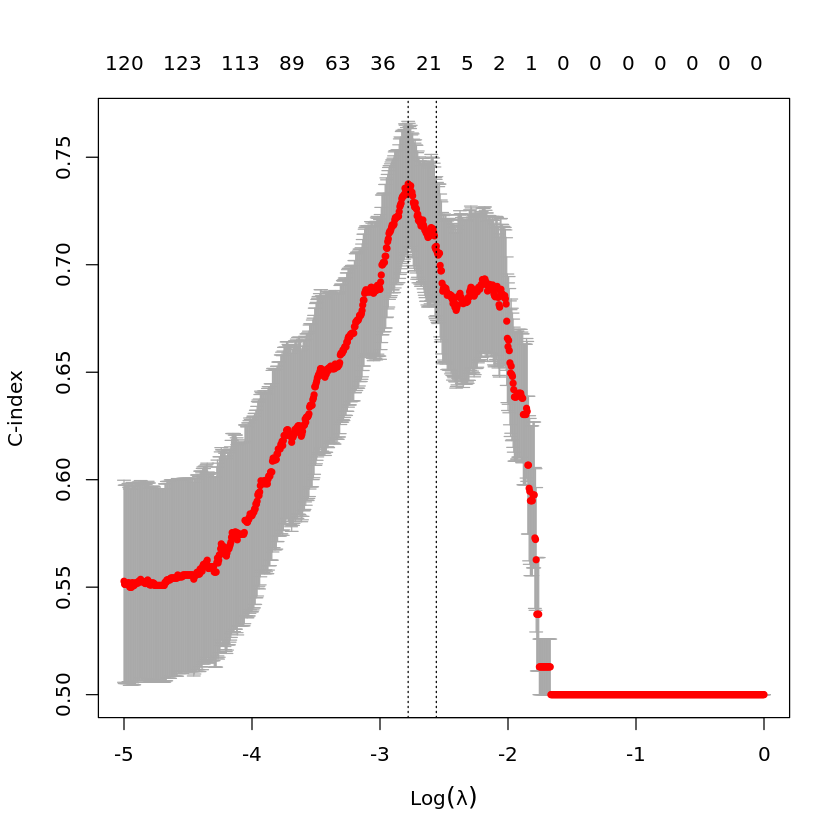

In [8]:
cv_cph_model
plot(cv_cph_model)

In [9]:
# Last index better than worst best score of any cancer model
lambda_idx <- max(which(cv_cph_model$cvm > worst_score))


mask_lambda <- cv_cph_model$lambda[lambda_idx]
mask_lambda_genes <- as.matrix(coef(cv_cph_model, s = mask_lambda))[, 1] != 0

In [10]:
cv_cph_model$lambda[lambda_idx]
cv_cph_model$cvm[lambda_idx]

[1] 0.04415717

[1] 0.6866803

In [11]:
cv_cph_model_coeffs <- as.matrix(coef(cv_cph_model, s = mask_lambda))
important_gene_df <- tibble(geneID = colnames(x)[mask_lambda_genes], coeff = cv_cph_model_coeffs[mask_lambda_genes])
nrow(important_gene_df)

[1] 43

In [12]:
param_length <- length(cv_cph_model$lambda)
# param_length
kept_idx <- rep(FALSE, param_length)
kept_idx[lambda_idx] = TRUE
best_idx <- rep(FALSE, param_length)
best_idx[[cv_cph_model$index["min",]]] = TRUE

In [13]:
fit_details_df <- tibble(
    cvm = cv_cph_model$cvm,
    lambda = cv_cph_model$lambda,
    cvlow = cv_cph_model$cvlo,
    cvup = cv_cph_model$cvup,
    nonzero = cv_cph_model$nzero,
    kept_idx = kept_idx,
    best_idx = best_idx,
)

In [14]:
if (save_res) {
    write_tsv(important_gene_df, paste0(dirs$analysis_dir, "/feature_selection/", unified_dsets[dset_idx], "_en_cph_results.tsv"))
    write_tsv(fit_details_df, paste0(dirs$analysis_dir, "/model_opt/", unified_dsets[dset_idx], "_en_cph_fit_data.tsv"))
}